# Lab 5 - Evaluation and Multi-Layer Perceptron

Members: Preston Tighe, Van Tran, Arturo Laguna

## Preparation
The dataset is a collection of handwritten digits taken from American Census Beareau employees. The data was collected by the NIST (National Institute of Science and Technology) and is a subset of their training data. The data comes from a larger database called the MNIST (Mixed National Institute of Science and Technology) database. The database is split into two datasets, a training and a testing. This dataset used in this project is a subset of size 60,000 images that are each 28x28 pixels.

This data is downloaded from:
http://yann.lecun.com/exdb/mnist/

Our task is to determine a digit 0-9 from a handwritten image of a specific digit.

The classification task is the following:
Given an array of feature vectors and target vector (10 classes: the numbers 0-9) containing the information described below, create a TLP that can correctly predict the target (10 classes: the numbers 0-9) given a feature vector.

This data is important because the classification of written digits can be useful. To list a couple of examples, reading credit cards, standardized test grading, written text to digital text conversion, etc.

Our prediction algorithm would need to be greater than 85% f1 score to be some what considered useful by interested parties. 95% would be ideal but 85% would be decent enough to be used in production for some applications.

In [1]:
# Imports

import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from scipy.misc import imread
from scipy.special import expit
from skimage.filters import roberts
from skimage.feature import daisy
from struct import unpack
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score

%matplotlib inline
%reload_ext  memory_profiler
plt.style.use('ggplot')

In [2]:
# Parse dataset, only use 5,000 images

binaryData = gzip.open('train-images-idx3-ubyte.gz', 'rb')
binaryLabels = gzip.open('train-labels-idx1-ubyte.gz', 'rb')

# Get metadata for images
# magic number means nothing to me so skip
binaryData.read(4)
binaryLabels.read(8)
numImages = binaryData.read(4)
numImages = unpack('>I', numImages)[0]
numImages = numImages - 55000
# Interpret packed binary data as '>I' which is big endian unsigned int
numRows = binaryData.read(4)
numRows = unpack('>I', numRows)[0]
numCols = binaryData.read(4)
numCols = unpack('>I', numCols)[0]

print(numImages) # should be 5000

# Now read into numpy array
images = np.empty([numImages, numRows, numCols], dtype=np.float32) 
Y = np.empty([numImages,], dtype=np.uint8)
for image in range(numImages):
    for row in range(numRows):
        for col in range(numCols):
                pixel = binaryData.read(1)  # Just a single byte
                pixel = unpack('>B', pixel)[0]
                images[image][row][col] = pixel
    label = binaryLabels.read(1)
    Y[image] = unpack('>B', label)[0]
print('done')

5000
done


In [3]:
# Bag of pixels model

X = np.empty([numImages, numRows * numCols])
for i in range(numImages):
    X[i] = images[i].flatten()

In [48]:
# Initial dataset description

n_samples, n_features = X.shape
_, h, w = images.shape
n_classes = len(Y)

print("Original n_samples: {}".format(n_samples))
print("Original n_features: {}".format(n_features))
print("Original n_class_labels: {}".format(n_classes))
print("Original image sizes: {} by {}".format(h,w))

Original n_samples: 5000
Original n_features: 150
Original n_class_labels: 5000
Original image sizes: 28 by 28


In [5]:
# Full PCA with 95% variance from Lab 3 graph by choosing the top 150 components
# Full PCA was the best of full, kernel, and randomized PCA

pca = PCA(n_components=150)
X = pca.fit_transform(X)
n_samples, n_features = X.shape
print("New n_samples: {}".format(n_samples))
print("New n_features: {}".format(n_features))

New n_samples: 5000
New n_features: 150


Our final dataset, X, is a table of 5000 images that have been flattened and dimensionally reduced using Full PCA to their top 150 eigenobjects using only 150 columns instead of 784 different columns that was initially based on the 28x28=784, height x width.

## Evaluation

### Metrics

We need to choose a method for scoring our classifier based on recall, precision, accuracy, and F1 score. There can only be 4 types of classifying when we classify an image. They are true positive (tp), true negative (tn), false positive (fp), and false negative (fn).

We just need to maximize true positives or true negatives. Accuracy doesn't take into account false positives so we need a metric that does this for us. We also want to minimize both false positives and false negatives. The F1 score does all this for us with the formula F1 = 2 (r * p) / (r + p). The F1 score is the harmonic mean using precision p = tp/(tp+fp) and recall r = tp/(tp+fn). We use the harmonic mean here because we are dealing with ratios when we are finding the probability.


### Dividing Data Methods

We also needed to choose a method for splitting our data set into smaller sets that more closely model a real-life scenario, as we don't get to train over every sample of data that comes in before needing to predict what its outcome will be. We have a couple tools to use for our training-test model selection: basic % based train-test, K-folds, shuffle splits, and stratified K-fold or shuffle splits. We know that our set is pretty much balanced at ~500 samples for each class. There is no need for any ordering of our set as it's not a time-series or any other ordered series. There shouldn't be any bias in the ordering of members of a class. We could reliably pick any of the model selection techniques and still get decent results. However, some of the techniques are significantly better than the others. We do want one of the stratified techniques as there is no reason we should introduce a class imbalance into the mix when there was none before. We also want to actually use a cross-validation technique rather than a simple test-train split, as it helps us to try out every data sample in a training set. This leaves us with either Stratified K-Fold splits or Stratified Shuffle Splits. As randomly selecting X members of each class shouldn't introduce any bias and using a Shuffle Split has the potential to be faster, our final Cross-Validation technique will be the Stratified Shuffle Split.

## Modeling

We created a 2 layer perception that allows the user to update the cost function and the first layer function.
<br>
<br>
**What updated:**  
cost function: cost  
feed forward: first layer  
gradient calculation: first layer & cost

In [6]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 first_func="sigmoid", cost_func="cross_entropy"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.first_func = first_func
        self.cost_func = cost_func
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights"""
        if self.first_func == "relu":
            init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
            W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

            init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
            W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        else: 
            W1_num_elems = (self.n_features_ + 1)*self.n_hidden
            W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
            W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

            W2_num_elems = (self.n_hidden + 1)*self.n_output_
            W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
            W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        if self.cost_func == "cross_entropy":
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        else: # quadratic
            cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.first_func == "sigmoid":
            A2 = self._sigmoid(Z1)
        elif self.first_func == "relu":
            A2 = self._relu(Z1)
        else: 
            A2 = Z1
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        if self.cost_func == "cross_entropy":
            sigma3 = (A3-Y_enc)
        else: # quadratic
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        
        if self.first_func == "sigmoid":
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        elif self.first_func == "relu":
            sigma2 = (W2.T @ sigma3) 
            Z1_with_bias = self._add_bias_unit(Z1,how='row')
            sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        else: # linear
            sigma2 = (W2.T @ sigma3)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    def score(self, x, y):
        res = self.predict(x)
        return f1_score(y, res, average='macro')
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
            
    def get_params(self, deep=True):
        return {
            'eta': self.eta,
            'n_hidden': self.n_hidden,
            'C': self.l2_C,
            'epochs': self.epochs,
            'first_func': self.first_func,
            'cost_func': self.cost_func
        }

In [7]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, print_progress=0,**kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.print_progress = print_progress
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            
            if self.print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(f1_score(y_data,self.predict(X_data), average='macro'))
            
        return self

In [8]:
# Testing the model

params =  dict(n_hidden=100, 
              C=0.0001, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              print_progress=True,
              cost_func="cross_entropy",
              first_func="sigmoid")
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
for train_index, test_index in cv.split(X, Y):
    pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print('How many of each class did we predict? ' + str(np.bincount(yhat)))

print('Total images in each class: ' + str(np.bincount(Y)))

Epoch: 200/200

f1 score: 0.668967174969
How many of each class did we predict? [ 90 126 100 104 107  85  95  94  86 113]
Total images in each class: [479 563 488 493 535 434 501 550 462 495]


Ran the test with quadratic as the cost function at first, thought I made a mistake. Realized the huge difference between quadratic and cross entropy. We just ran the first fit and predict using our custom TLPMiniBatch with random but calculated parameters.

## Hyperparameter Tuning

For hyperparameter tuning we decided to tune the regularization and eta parameters using the cross entropy cost function and the sigmoid first function.

After calculation of an initial 48 different scenarios and getting the best F1 score of 86.8%, we decided C=0.5 and eta=0.005 was best for the 1st scenario. I'd say that a F1 score of 86.8% is pretty darn good for predicting a number from images using our own implementation.

Based on the visualization from the first 48 scenarios, we came up with 40 other scenarios to furthur try and increase the F1 score. We got a better F1 score of 88.5% using C=0.5 and eta=0.003.

In [9]:
def find_best_hyper_params(C_vals, eta_vals):
    results = []
    scenario_counter = 1
    print('Scenario Completed: ',end='')
    cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
    for c in C_vals:
        for eta in eta_vals:
            params =  dict(n_hidden=100, 
                  C=c, # tradeoff L2 regularizer
                  epochs=200, # iterations
                  eta=eta,  # learning rate
                  random_state=1,
                  cost_func="cross_entropy",
                  first_func="sigmoid")
            pl = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
            for train_index, test_index in cv.split(X, Y):
                pl.fit(X[train_index], Y[train_index])
                yhat = pl.predict(X[test_index])
                results.append(f1_score(Y[test_index], yhat, average='macro'))
                print(str(scenario_counter) + " ", end='')
                scenario_counter += 1
    print()
    print('All scenario\'s completed.')
    print('Results: ' + str(results))
    return results

def graph_hyper_params(C_vals, eta_vals, results):
    plt.style.use('ggplot')
    plt.figure(figsize=(15,15))  

    start_index = 0
    for i, c in enumerate(C_vals):
        end_index = start_index + len(eta_vals)
        plt.plot(eta_vals, results[start_index:end_index], label="C=" + str(c), marker='o')
        start_index = end_index


    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("F1 score with custom C and eta hyperparams")
    plt.xlabel("eta value")
    plt.ylabel("F1 score")
    plt.show()
    
def print_best_hyper_params(C_vals, eta_vals, results):
    max_index = np.argmax(results)
    current_index = 0
    for c in C_vals:
        for eta in eta_vals:
            if current_index == max_index:
                print('Best C: ' + str(c) + ' - Best eta: ' + str(eta) + ' - Best F1 score: ' + str(np.max(results)))
            current_index += 1

In [16]:
warnings.filterwarnings('ignore')

C_vals = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
eta_vals = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

results = find_best_hyper_params(C_vals, eta_vals)

Scenario Completed: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
All scenario's completed.
Results: [0.66896717496886726, 0.84145842214091382, 0.86703526954792642, 0.65424910194321773, 0.62928342725554487, 0.61493937831314482, 0.66896717496886726, 0.84145842214091382, 0.86703526954792642, 0.65525162218926136, 0.57339388067079367, 0.66846063840041037, 0.66896717496886726, 0.84145842214091382, 0.86703526954792642, 0.6603149133514904, 0.58722912217845458, 0.65868729383433033, 0.66896717496886726, 0.84145842214091382, 0.86373681052341689, 0.65722769320351659, 0.6099581505846936, 0.62785157693208926, 0.66896717496886726, 0.84145842214091382, 0.86589263000176842, 0.65548774778470498, 0.56611234346565431, 0.64764296411570377, 0.66896717496886726, 0.84238568000170544, 0.86652921029664287, 0.65425318153440692, 0.55015983906463284, 0.59040959660398085, 0.66896717496886726, 0.84238568000170544, 0.8677309628

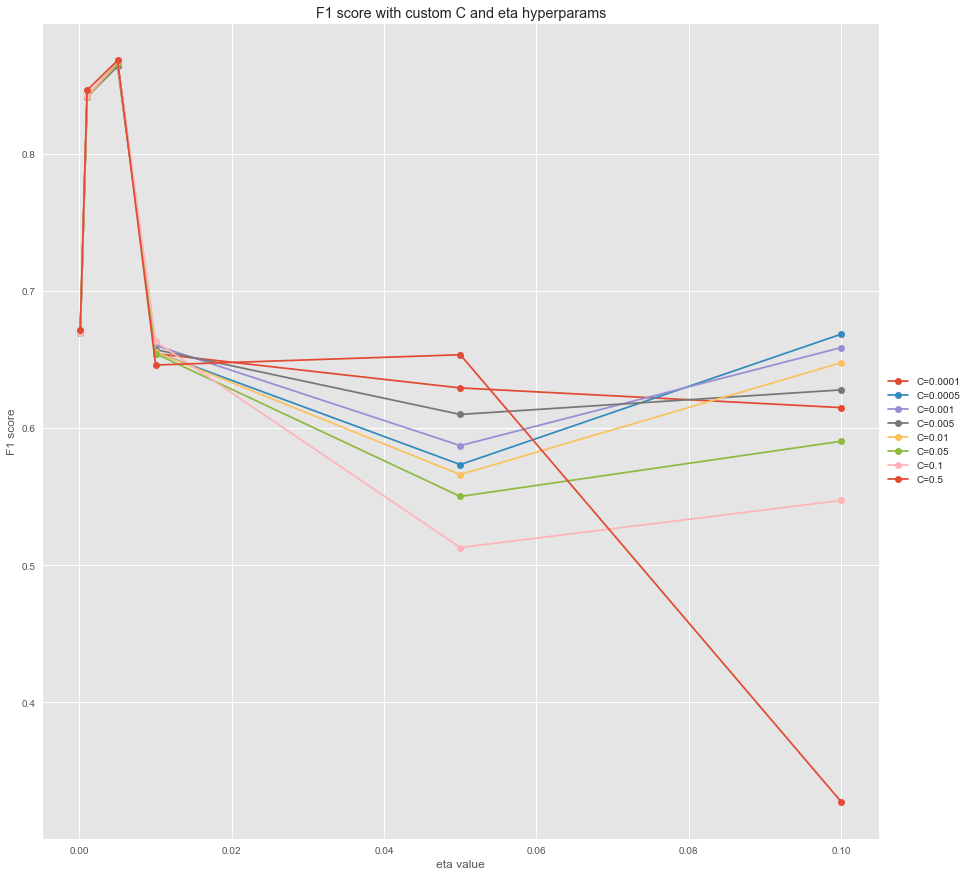

In [17]:
graph_hyper_params(C_vals, eta_vals, results)

In [18]:
print_best_hyper_params(C_vals, eta_vals, results)

Best C: 0.5 - Best eta: 0.005 - Best F1 score: 0.868023812537


#### Hyper Params Test 2 based on 1st test

In [23]:
C_vals_test2 = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
eta_vals_test2 = [0.003, 0.004, 0.005, 0.006, 0.007]

results_test2 = find_best_hyper_params(C_vals_test2, eta_vals_test2)

Scenario Completed: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
All scenario's completed.
Results: [0.88218127414724967, 0.87603028683040629, 0.86703526954792642, 0.78979815324461256, 0.69806337495960391, 0.88212157160256055, 0.87603028683040629, 0.86703526954792642, 0.79171885599298275, 0.69806337495960391, 0.88212157160256055, 0.87603028683040629, 0.86703526954792642, 0.79066438333787736, 0.69806337495960391, 0.88212157160256055, 0.87798401322387076, 0.86373681052341689, 0.79542680275350608, 0.69694538729831845, 0.88212157160256055, 0.8759434312983968, 0.86589263000176842, 0.7934721299969586, 0.69585566896904427, 0.87904013855157692, 0.88120749391440911, 0.86652921029664287, 0.81106196919405937, 0.70221674757741159, 0.88117423171063758, 0.88234503589963431, 0.8677309628240909, 0.82397883011534501, 0.70526402086753048, 0.8854118872048975, 0.88261759725043498, 0.86802381253681626, 0.88121190139147987, 0.772893525250836

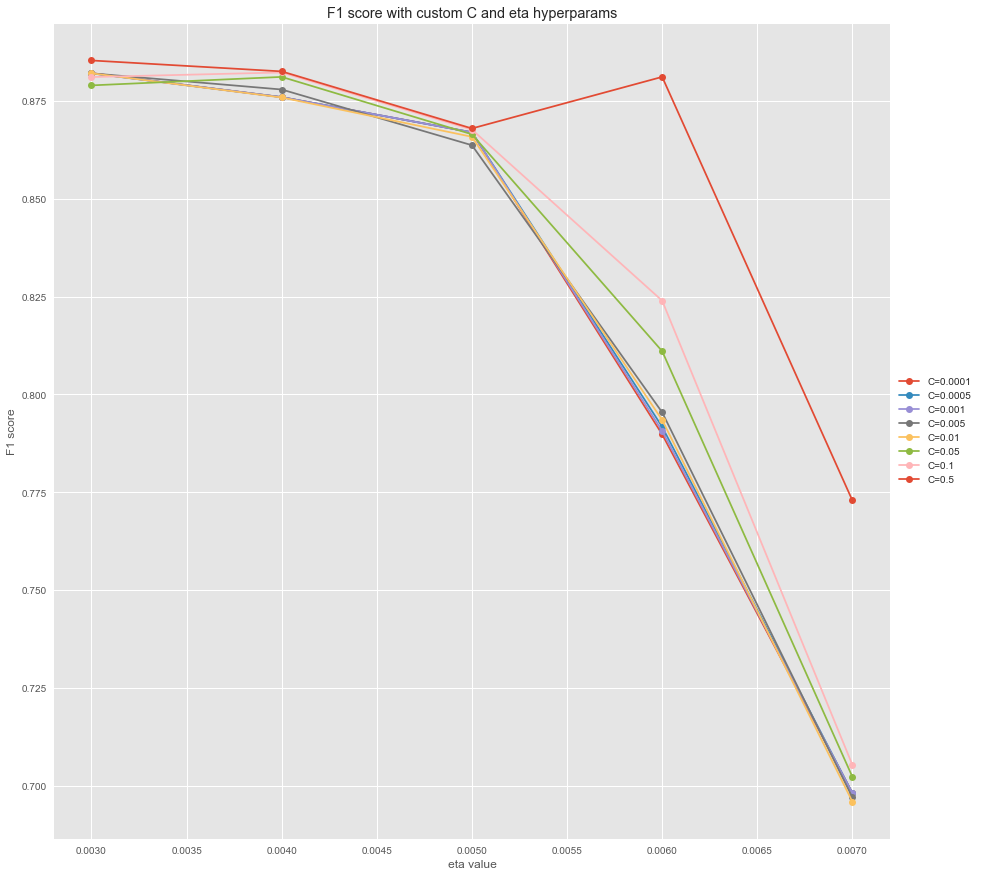

In [25]:
graph_hyper_params(C_vals_test2, eta_vals_test2, results_test2)

In [26]:
print_best_hyper_params(C_vals_test2, eta_vals_test2, results_test2)

Best C: 0.5 - Best eta: 0.003 - Best F1 score: 0.885411887205


## Scikit Comparison

Finally we compared our hyper parameterized tuned cross entropy sigmoid model against scikit-learn's own MLP Classifier using default parameters.

Their MLP Classifier defaults to 100 hidden layers, relu, an adam gradient solver.

Of the 2 different implementations we compared the F1 scores, memory usage, and run time. Scikit had better performance on all these metrics.

However, the scikit implementation with our preprocessing techniques hovers around an F1 score of .55. This means our image processing techniques is not great with this model for image detection. Hopefully as our It was still a great exploration into different types of image processing techniques. 

In [33]:
# SKLearn's implementation
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(X, Y):
    %time %memit pl.fit(X[train_index], Y[train_index])
    yhat = pl.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

peak memory: 157.57 MiB, increment: 16.22 MiB
Wall time: 4.7 s
f1 score: 0.912957188949
[ 95 117  96  97 113  84  99 108  94  97]


In [37]:
# Our implementation
cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)

params =  dict(n_hidden=100, 
      C=0.5, # tradeoff L2 regularizer
      epochs=200, # iterations
      eta=0.003,  # learning rate
      random_state=1,
      cost_func="cross_entropy",
      first_func="sigmoid")
p2 = Pipeline([('scaler', StandardScaler()), ('TLP', TLPMiniBatch(**params))])
for train_index, test_index in cv.split(X, Y):
    %time %memit p2.fit(X[train_index], Y[train_index])
    yhat = p2.predict(X[test_index])
    print('f1 score:', f1_score(Y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

peak memory: 180.62 MiB, increment: 41.71 MiB
Wall time: 14.3 s
f1 score: 0.885411887205
[ 92 120  88  95 112  90 107 116  81  99]


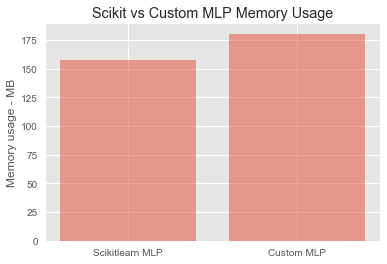

In [43]:
plt.style.use('ggplot')

objects = ['Scikitlearn MLP', 'Custom MLP']

y_pos = np.arange(len(objects))

performance = [157.57, 180.62]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
plt.ylabel('Memory usage - MB')
plt.title('Scikit vs Custom MLP Memory Usage')

plt.show()

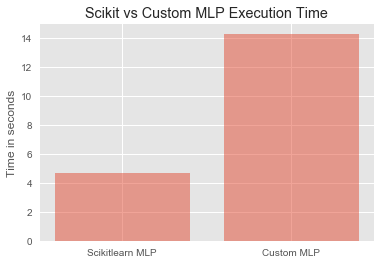

In [44]:
plt.style.use('ggplot')

objects = ['Scikitlearn MLP', 'Custom MLP']

y_pos = np.arange(len(objects))

performance = [4.7, 14.3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
plt.ylabel("Time in seconds")
plt.title("Scikit vs Custom MLP Execution Time")

plt.show()

Our version of MLP performed 3 times as long as Scikit Learn's implementation while only performing a little bit worse in terms of memory usage

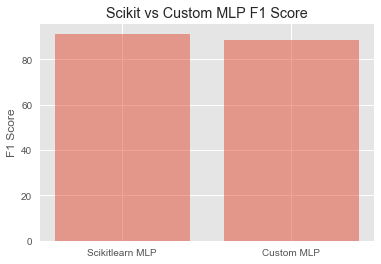

In [45]:
plt.style.use('ggplot')

objects = ['Scikitlearn MLP', 'Custom MLP']

y_pos = np.arange(len(objects))

performance = [91.3, 88.5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
plt.ylabel("F1 Score")
plt.title("Scikit vs Custom MLP F1 Score")

plt.show()

The off by less than 3% for the F1 score seemed like we almost accomplished being better than scikit learn in 1 metric for our giving data.

### RandomizedSearchCV
Attempting to run this for 24 hours to see if it completes for 4 hyper parameters :)

In [ ]:
def super_long_randomized_search():
    params = dict(
        tlp__n_hidden = [100],
        tlp__eta = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1],
        tlp__epochs = [200],
        tlp__C = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
        tlp__first_func = ('sigmoid', 'linear', 'relu'),
        tlp__cost_func = ('quadratic', 'cross_entropy'),
    )

    pl = Pipeline([('scaler', StandardScaler()), ('tlp', TLPMiniBatch())])
    cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
    gs = RandomizedSearchCV(pl, params, n_jobs=50, scoring='f1_macro', cv=cv)
    gs.fit(X, Y)
    print('Best score: ' + str(gs.best_score_))
    
super_long_randomized_search()